## Example 7.13 (Identical Twin Experiment)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Generate reference model and observations
Generate reference model by means of the implicit midpoint method.

In [379]:
Nout = 12
STEPS = 5500
N = STEPS * Nout

# initial conditions
x0 = -0.587276
y0 = -0.563678
z0 = 16.8708

dt = 0.01

In [380]:
import odespy

def f(u, t):
    x, y, z = u
    return [10.*(y-x), x*(28. - z)-y, x*y - 8./3 * z]

solver = odespy.MidpointImplicit(f)
solver.set_initial_condition([x0, y0, z0])

time_points = np.linspace(0, 600, N+1)

u, t_ref = solver.solve(time_points)

x_ref = u[:,0]
y_ref = u[:,1]
z_ref = u[:,2]

Plot the reference model

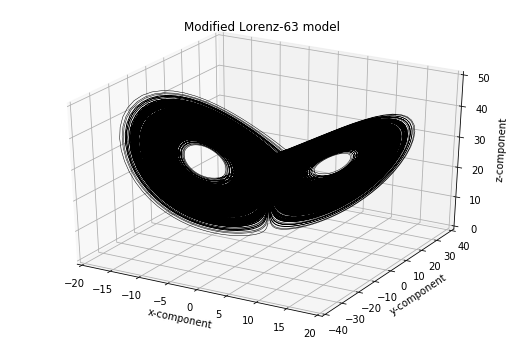

In [381]:
from mpl_toolkits import mplot3d

figT = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot3D(x_ref, y_ref, z_ref, 'k', linewidth=0.5)
ax.set_xlabel('x-component')
ax.set_ylabel('y-component')
ax.set_zlabel('z-component')
ax.set_title('Modified Lorenz-63 model')

ax.set_xlim(-20,20)
ax.set_ylim(-40,40)
ax.set_zlim(0,50)
plt.show()

Add measurement errors to reference model for observations. Measurement errors are generated by means of the tent map.

In [384]:
Nmeas = np.ceil(240./Nout).astype('int')
meas = np.zeros((N*Nmeas,2))

a = 4.
fakt = 1.99999
eta1 = a * (2**(-1./2) - 0.5)

for i in range(N*Nmeas):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
# from eqn(1.10), take every 12th tent map iteration as a measurement error (intervals of 4 for x,y,z).
err = np.zeros((N/Nout+1, 3))
err[1:,0] = meas[:,1][::12].reshape(-1,20).sum(axis=-1)
err[1:,1] = meas[:,1][4::12].reshape(-1,20).sum(axis=-1)
err[1:,2] = meas[:,1][8::12].reshape(-1,20).sum(axis=-1)
err /= 20.

# populate observations array where observations = reference + error
obs = np.zeros((STEPS+1,4))
obs[:,0] = t_ref[::Nout]
obs[:,1] = x_ref[::Nout] #+ err[:,0]
obs[:,2] = y_ref[::Nout] #+ err[:,1]
obs[:,3] = z_ref[::Nout] #+ err[:,2]

# populate reference model at observation times
ref_obs = np.vstack((x_ref[1::Nout],y_ref[1::Nout],z_ref[1::Nout])).T

(5501, 4)
(5500, 3)


Plot the observations

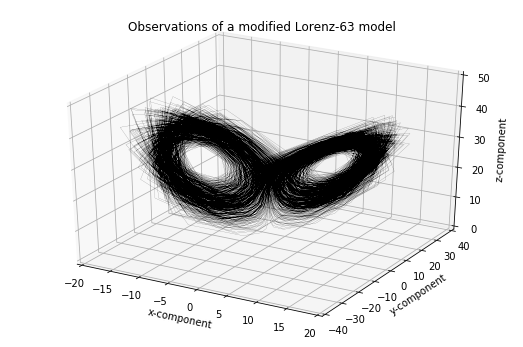

In [385]:
from mpl_toolkits import mplot3d

figT = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot3D(obs[:,1], obs[:,2], obs[:,3], 'k', linewidth=0.1)
ax.set_xlabel('x-component')
ax.set_ylabel('y-component')
ax.set_zlabel('z-component')
ax.set_title('Observations of a modified Lorenz-63 model')

ax.set_xlim(-20,20)
ax.set_ylim(-40,40)
ax.set_zlim(0,50)
plt.show()

### Generate forecasts and assimilate observations by means of SIR

In [334]:
# define residual resampling function
def resampling(X,w,M,J):
    wm = M*w
    wi = np.floor(wm)
    nc = np.sum(wi).astype(int)

    A = np.zeros((J,nc))
    X = X.reshape(J,-1)
    
    if (nc > 0):
        k = 0
        for i in range(M):
            for j in range(int(wi[i])):
                #if j > 0:
                A[:,k] = X[:,i]
                k += 1
    else:
        A = np.zeros((J,0))
        
    wmd = wm - wi
    wmd /= np.sum(wmd)
    Nk = M - nc
    
    B = np.zeros((J,Nk))
    
    if (Nk > 0):
        exponent = 1./(np.arange(1,Nk+1)[::-1]).astype(float)
        u = np.cumprod(np.power(np.random.rand(Nk),exponent))
        u = u[::-1]

        wcu = np.cumsum(wmd)
        
        ind = np.zeros((Nk)).astype(int)
        kk = 0
        
        for ll in range(Nk):
            while (wcu[kk] < u[ll]):
                kk += 1
                
            ind[ll] = kk
        B = X[:,ind]
        
    else:
        B = np.zeros((J,0))

    return A, B

In [364]:
dt = 0.01
R = 9.

sigma = 0.1

m = np.arange(10,11,10)
J = len(m)

rmse_SIR = np.zeros((J))
effective = np.zeros((J,STEPS+1))

# loop over ensemble sizes
for k in range(J):
    M = m[k]
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t = np.zeros((STEPS+1))
    
    weights = 1./M * np.ones(M)
    
    xm_SIR = np.zeros((STEPS+1))
    ym_SIR = np.zeros((STEPS+1))
    zm_SIR = np.zeros((STEPS+1))
    
#     xm_SIR[0] = np.mean(x)
#     ym_SIR[0] = np.mean(y)
#     zm_SIR[0] = np.mean(z)

    xm_SIR[0] = np.dot(weights,x)
    ym_SIR[0] = np.dot(weights,y)
    zm_SIR[0] = np.dot(weights,z)

    rmse_SIR[k] = 0.
    effective[k,0] = 1./ np.sum(weights**2)
    
    for j in range(STEPS):
#         xo = x
#         yo = y
#         zo = z

        xh = x
        yh = y
        zh = z
        
#         x_f = np.zeros((M))
#         y_f = np.zeros((M))
#         z_f = np.zeros((M))

#         for i in range(M):
#             solver.set_initial_condition([xo[i], yo[i], zo[i]])
#             t_window = np.linspace(0,0.12,Nout)
#             u, _ = solver.solve(t_window)
            
#             x_f[i] = u[-1][0]
#             y_f[i] = u[-1][1]
#             z_f[i] = u[-1][2]

        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo)
            yh = yo + dt * (xo * (28. - zo) - yo)
            zh = zo + dt * (xo * yo - 8./3 * zo)
        
        x_f = xh
        y_f = yh
        z_f = zh
        
        r = (x_f - obs[j+1,1])**2 + (y_f - obs[j+1,2])**2 + (z_f - obs[j+1,3])**2
        weights = np.exp(-r / (R * 2.)) * weights
        weights /= np.sum(weights)

        x = x_f
        y = y_f
        z = z_f
        
        xm_SIR[j+1] = np.dot(weights,x)
        ym_SIR[j+1] = np.dot(weights,y)
        zm_SIR[j+1] = np.dot(weights,z)
        t[j+1] = dt * Nout * (j+1)
        
#         err = (xm_SIR[j] - ref_obs[j,0])**2 + (ym_SIR[j] - ref_obs[j,1])**2 + (zm_SIR[j] - ref_obs[j,2])**2
#         rmse_SIR[k] += np.mean(err)
        
        effective[k,j+1] = 1./ np.sum(weights**2)
        
        if (effective[k,j+1] < M/2.):
            X = np.vstack((x,y,z))
            A, B = resampling(X,weights,M,3)
            
            # reinitialise weights to be equal
            weights = 1./M * np.ones(M)

            x = np.hstack((A[0,:],B[0,:])).T
            y = np.hstack((A[1,:],B[1,:])).T
            z = np.hstack((A[2,:],B[2,:])).T
        
        X = np.vstack((x,y,z))
        dX = X - np.mean(X, axis=1).reshape(-1,1)

        P = dX[:,:,None] * dX.T[None,:,:]
        P = P.sum(axis=1)/(M-1)
        tau = 0.5
        
        for i in range(M):
            X[:,i] = np.random.multivariate_normal(X[:,i],tau*P)
        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
# rmse_SIR = np.sqrt(rmse_SIR/STEPS/3.)

7.57309465907378


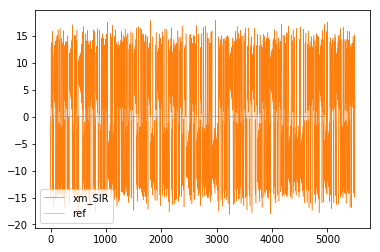

9.493947370697818


In [388]:
rmse_X = (xm_SIR[1:10] - ref_obs[1:10,0])**2
rmse_X = np.mean(rmse_X)
rmse_X = np.sqrt(rmse_X)
print(rmse_X)

figtest = plt.figure()
plt.plot(xm_SIR, lw=0.5, label="xm_SIR")
plt.plot(ref_obs[:,0], lw=0.5, label="ref")
plt.legend()
plt.show()

rmse_Y = (ym_SIR[1:10] - ref_obs[1:10,1])**2
rmse_Y = np.mean(rmse_Y)
rmse_Y = np.sqrt(rmse_Y)
print(rmse_Y)

# rmse_Z = (zm_SIR[1:] - ref_obs[:,2])**2
# rmse_Z = np.mean(rmse_Z)
# rmse_Z = np.sqrt(rmse_Z)
# print(rmse_Z)

### Generate forecasts and assimilate observations by means of Ensemble Transform Particle Filter

In [452]:
from scipy.linalg import sqrtm
from pyemd import emd_with_flow

dt = 0.01
R = 9.
STEPS = 500
sigma = 0.1

m = np.arange(80,81,10)
J = len(m)

rmse_SIR = np.zeros((J))
effective = np.zeros((J,STEPS+1))

rmse_x = np.zeros((J))
rmse_y = np.zeros((J))
rmse_z = np.zeros((J))

# loop over ensemble sizes
for k in range(J):
    M = m[k]
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t = np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    xh = np.zeros((M))
    yh = np.zeros((M))
    zh = np.zeros((M))
    
    rmse_x[k] = 0.
    rmse_y[k] = 0.
    rmse_z[k] = 0.
    
    for j in range(STEPS):
        xo = x
        yo = y
        zo = z
        
        err = 1e9
        
        for i in range(M):
            solver.set_initial_condition([xo[i], yo[i], zo[i]])
            t_window = np.linspace(0,0.12,Nout)
            u, _ = solver.solve(t_window)
            
            xh[i] = u[-1][0]
            yh[i] = u[-1][1]
            zh[i] = u[-1][2]

        x = xh
        y = yh
        z = zh
        
        r = (x - obs[j+1,1])**2 + (y - obs[j+1,2])**2 + (z - obs[j+1,3])**2
        ww = np.exp(-r / (2. * R))
        ww /= np.sum(ww)
        
        X = np.vstack((x,y,z))
        CO = np.dot(X.T,X)
        CO = np.diag(CO) * np.ones((1,M)) - 2. * CO + np.ones((M,1)) * np.diag(CO).T

        dist, T = emd_with_flow(ww,np.ones(M)/M, CO, -1)
        T = np.array(T)
        T = T*M
        
        X = np.dot(X,T)
        
        dX = X - np.mean(X, axis=1).reshape(-1,1)

        P = dX[:,:,None] * dX.T[None,:,:]
        P = P.sum(axis=1)/(M-1)
        taus = np.arange(0,51)/100.
        
        minX = np.copy(X)
        minx_f = np.empty_like(x_f)
        
        for tau in taus:
            for i in range(M):
                minX[:,i] = np.random.multivariate_normal(minX[:,i],tau*P)

            minx_f[j+1] = np.mean(minX[0,:])

            if ((minx_f[j+1] - ref_obs[j+1,0])**2 < err):
                err = (minx_f[j+1] - ref_obs[j+1,0])**2
                minTau = tau
                
        for i in range(M):        
            X[:,i] = np.random.multivariate_normal(X[:,i],minTau*P)

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]

        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        
        rmse_x[k] = rmse_x[k] + (x_f[j+1] - ref_obs[j+1,0])**2
        rmse_y[k] = rmse_y[k] + (y_f[j+1] - ref_obs[j+1,1])**2
        rmse_z[k] = rmse_z[k] + (z_f[j+1] - ref_obs[j+1,2])**2

        t[j+1] = dt * Nout * (j+1)

    rmse_x[k] = np.sqrt(rmse_x[k] / STEPS)
    rmse_y[k] = np.sqrt(rmse_y[k] / STEPS)
    rmse_z[k] = np.sqrt(rmse_z[k] / STEPS)

In [455]:
print(rmse_x)
print(rmse_y)
print(rmse_z)

[10.96743004]
[12.48761881]
[12.33064566]
